In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load data 

In [2]:
path_to_data = '../external_data/mixmhcpred/TableS2.txt'
# ignore the first row (header)
df = pd.read_csv(path_to_data, sep='\t', skiprows=1)

<Axes: >

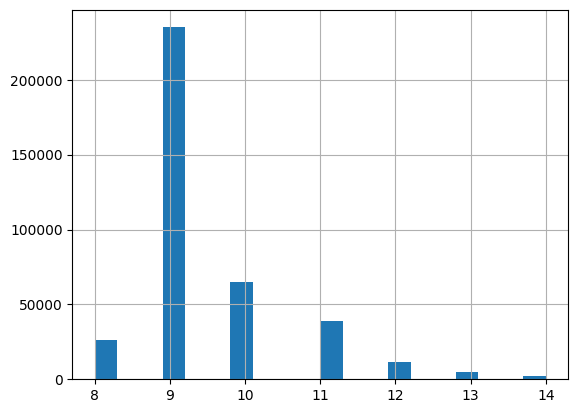

In [3]:
# length distributions of peptides
df['Peptide_Lengths'] = df['Peptide'].apply(len)
df['Peptide_Lengths'].hist(bins=20)

# Build XgBoost model for peptides with length of 9

In [4]:
df_9 = df[df['Peptide_Lengths'] == 9]

alleles_to_exclude = ['C1505', 'B1401', 'C0704', 'B4801', 'C1602', 'B1803']
df_9 = df_9[~df_9['Allele'].isin(alleles_to_exclude)]

In [5]:
ninemer_encoder = OneHotEncoder()
X_encoded = np.array([list(s) for s in df_9['Peptide'].values])
X_encoded = ninemer_encoder.fit_transform(X_encoded).toarray()

ninemer_label_encoder = LabelEncoder()
# Fit the encoder on your class labels and transform them into numerical labels
y_labeled = ninemer_label_encoder.fit_transform(df_9['Allele'].values)


In [6]:
X_train_encoded, X_test_encoded, y_train_labeled, y_test_labeled = train_test_split(X_encoded, y_labeled, test_size=0.1, random_state=1)
X_train_encoded, X_valid_encoded, y_train_labeled, y_valid_encoded = train_test_split(X_train_encoded, y_train_labeled, test_size=0.12, random_state=1) # 0.12 x 0.9 ~ 0.1

In [7]:
num_classes = len(np.unique(df_9['Allele']))
model_l9 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric = "mlogloss"
)

# Train the model while monitoring the evaluation metrics
model_l9.fit(
    X_train_encoded, y_train_labeled,
    eval_set=[(X_train_encoded, y_train_labeled), (X_test_encoded, y_test_labeled)],  # Datasets for evaluation
    verbose=True
)


[0]	validation_0-mlogloss:3.88314	validation_1-mlogloss:3.87453
[1]	validation_0-mlogloss:3.64467	validation_1-mlogloss:3.63847
[2]	validation_0-mlogloss:3.47980	validation_1-mlogloss:3.47550
[3]	validation_0-mlogloss:3.35050	validation_1-mlogloss:3.34866
[4]	validation_0-mlogloss:3.24478	validation_1-mlogloss:3.24400
[5]	validation_0-mlogloss:3.15449	validation_1-mlogloss:3.15507
[6]	validation_0-mlogloss:3.07575	validation_1-mlogloss:3.07716
[7]	validation_0-mlogloss:3.00691	validation_1-mlogloss:3.00918
[8]	validation_0-mlogloss:2.94591	validation_1-mlogloss:2.94895
[9]	validation_0-mlogloss:2.89021	validation_1-mlogloss:2.89413
[10]	validation_0-mlogloss:2.84056	validation_1-mlogloss:2.84522
[11]	validation_0-mlogloss:2.79471	validation_1-mlogloss:2.80020
[12]	validation_0-mlogloss:2.75328	validation_1-mlogloss:2.75955
[13]	validation_0-mlogloss:2.71504	validation_1-mlogloss:2.72202
[14]	validation_0-mlogloss:2.67988	validation_1-mlogloss:2.68744
[15]	validation_0-mlogloss:2.64703	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=113, num_parallel_tree=None, ...)

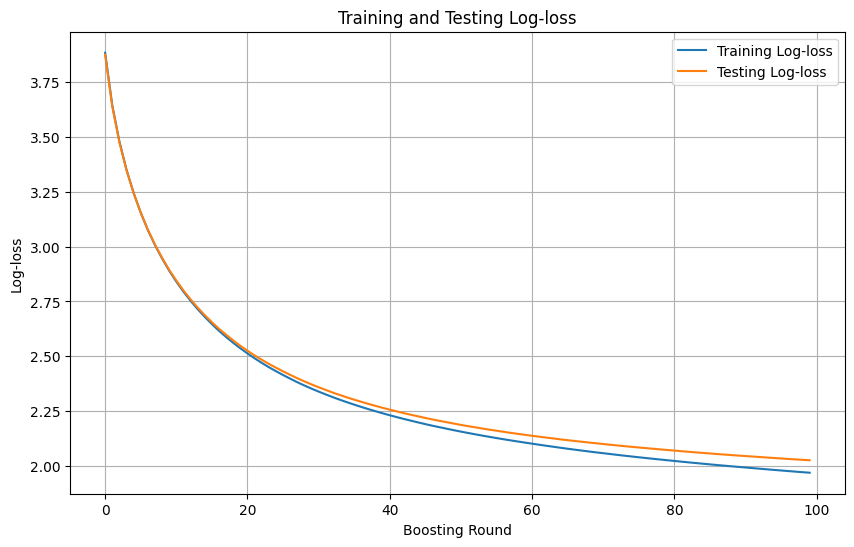

In [9]:
# Get the evaluation results for both training and validation sets
results = model_l9.evals_result()

# Extract log-loss values
train_logloss = results["validation_0"]["mlogloss"]
test_logloss = results["validation_1"]["mlogloss"]

# Plot log-loss
plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label="Training Log-loss")
plt.plot(test_logloss, label="Testing Log-loss")
plt.xlabel("Boosting Round")
plt.ylabel("Log-loss")
plt.title("Training and Testing Log-loss")
plt.legend()
plt.grid(True)
plt.show()

Compare to MixMHCpred

In [9]:

test_peptides = ninemer_encoder.inverse_transform(X_test_encoded)
test_peptides = ["".join(x) for x in test_peptides]
test_peptides_file = "/Users/halasadi/code/pmhc_methods_tf/internal_data/test_peptides.fasta"

# Open the output file for writing
with open(test_peptides_file, "w") as fasta_file:
    for peptide in test_peptides:
        # Write the peptide name as the header line starting with ">"
        fasta_file.write(f">{peptide}\n")
        fasta_file.write(f"{peptide}\n")


true_labels = ninemer_label_encoder.inverse_transform(y_test_labeled)
df_9_test_truth = pd.DataFrame({'Peptide':test_peptides, 'Allele': true_labels})

In [10]:
import subprocess

out_file = '/Users/halasadi/code/pmhc_methods_tf/internal_data/out.txt'
command = ["/Users/halasadi/code/MixMHCpred-master/MixMHCpred", "-i", test_peptides_file, '-o', out_file, '-a', ",".join(np.unique(df_9['Allele'].values))]
try:
    output = subprocess.check_output(command, stderr=subprocess.STDOUT, universal_newlines=True)
except subprocess.CalledProcessError as e:
    print(f"Command failed with return code {e.returncode}")

In [11]:
y_pred = model_l9.predict(X_test_encoded)
pred_labels = ninemer_label_encoder.inverse_transform(y_pred)
accuracy = accuracy_score(pred_labels, df_9_test_truth['Allele'].values)
print(f"Accuracy of XgBoost: {accuracy}")

pred_p = model_l9.predict_proba(X_test_encoded)
max_p = np.amax(pred_p, axis=1)
accuracy = accuracy_score(pred_labels[max_p > 0.9], df_9_test_truth['Allele'][max_p > 0.9].values)
print(f"Accuracy of High Confidence XgBoost Calls: {accuracy}")

Accuracy of XgBoost: 0.4086190759806007
Accuracy of High Confidence XgBoost Calls: 0.9375


In [12]:
df_out = pd.read_csv(out_file, sep='\t', comment='#')
mixmhcpredout = df_out[['Peptide', 'BestAllele']]
mixmhcpredout = mixmhcpredout.merge(df_9_test_truth, on = "Peptide", how = "left")
accuracy = accuracy_score(mixmhcpredout['Allele'], mixmhcpredout['BestAllele'])
print(f"Accuracy of MixMHCPred: {accuracy}")

Accuracy of MixMHCPred: 0.3341403483414035


It looks like our XgBoost model beats the PWM approach by a noticeable margin!

# Build XgBoost model for peptides with length 10 and investigating whether data from peptide lengths == 9 helps.

Here we will use our XgBoost model trained on 9mers on 10mers 

In [10]:
df_10 = df[df['Peptide_Lengths'] == 10]

In [11]:
#allele_counts = df_10['Allele'].value_counts()
# Create a mask to filter IDs that appear at least 10 times
#mask = df_10['Allele'].map(allele_counts) >= 10
# Apply the mask to filter the DataFrame
#df_10 = df_10[mask]

alleles_to_exclude = ['C1505', 'B1401', 'C0704', 'B4801', 'C1602', 'B1803']
df_10 = df_10[~df_10['Allele'].isin(alleles_to_exclude)]

Out of curosity, let's investigate whether there is signal in the 9mer data that has predictive signal in the 10mer data. 

In [12]:
all_substrings_of_length_9 = [(s[:9], s[1:10]) for s in df_10['Peptide'].values]


sub_peptides_1 = [tu[0] for tu in all_substrings_of_length_9]
x_substr_9_1 = np.array([list(s) for s in sub_peptides_1])
x_substr_9_1 = ninemer_encoder.fit_transform(x_substr_9_1).toarray()

sub_peptides_2 = [tu[1] for tu in all_substrings_of_length_9]
x_substr_9_2 = np.array([list(s) for s in sub_peptides_2])
x_substr_9_2 = ninemer_encoder.fit_transform(x_substr_9_2).toarray()

y_pred_9_1 = ninemer_label_encoder.inverse_transform(model_l9.predict(x_substr_9_1))
y_pred_9_2 = ninemer_label_encoder.inverse_transform(model_l9.predict(x_substr_9_2))

max_p1 = np.amax(model_l9.predict_proba(x_substr_9_1), axis=1)
max_p2 = np.amax(model_l9.predict_proba(x_substr_9_2), axis=1)
y_pred_combined = y_pred_9_1
y_pred_combined[max_p2 > max_p1] = y_pred_9_2[max_p2 > max_p1]


print(accuracy_score(y_pred_9_1, df_10['Allele'].values))
print(accuracy_score(y_pred_9_2, df_10['Allele'].values))
print(accuracy_score(y_pred_combined, df_10['Allele'].values))

0.20290680666964328
0.11958245446567413
0.20290680666964328


Yes! There does seem to be substantial signal that is transferable across 9,10 mers. Interestingly, the left aligned peptides do a lot better, which suggests to me that position matters quite a bit here! 

Then we will train a new classifier based on 10mer data only

In [22]:
tenmer_encoder = OneHotEncoder()
X_encoded = np.array([list(s) for s in df_10['Peptide'].values])
X_encoded = tenmer_encoder.fit_transform(X_encoded).toarray()

#tenmer_label_encoder = LabelEncoder()
# Fit the encoder on your class labels and transform them into numerical labels
y_labeled = ninemer_label_encoder.fit_transform(df_10['Allele'].values)


In [23]:
X_train_encoded, X_test_encoded, y_train_labeled, y_test_labeled = train_test_split(X_encoded, y_labeled, test_size=0.1, random_state=1)
X_train_encoded, X_valid_encoded, y_train_labeled, y_valid_labeled = train_test_split(X_train_encoded, y_train_labeled, test_size=0.12, random_state=1) # 0.12 x 0.9 ~ 0.1

In [24]:
num_classes = len(np.unique(y_train_labeled))
model_l10 = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric = "mlogloss"
)

# Train the model while monitoring the evaluation metrics
model_l10.fit(
    X_train_encoded, y_train_labeled,
    eval_set=[(X_train_encoded, y_train_labeled), (X_valid_encoded, y_valid_labeled)],  # Datasets for evaluation
    verbose=True
)


[0]	validation_0-mlogloss:3.55364	validation_1-mlogloss:3.58623
[1]	validation_0-mlogloss:3.31188	validation_1-mlogloss:3.34902
[2]	validation_0-mlogloss:3.14406	validation_1-mlogloss:3.18681
[3]	validation_0-mlogloss:3.01267	validation_1-mlogloss:3.05870
[4]	validation_0-mlogloss:2.90356	validation_1-mlogloss:2.95401
[5]	validation_0-mlogloss:2.81033	validation_1-mlogloss:2.86505
[6]	validation_0-mlogloss:2.72951	validation_1-mlogloss:2.78594
[7]	validation_0-mlogloss:2.65895	validation_1-mlogloss:2.71868
[8]	validation_0-mlogloss:2.59554	validation_1-mlogloss:2.65715
[9]	validation_0-mlogloss:2.53921	validation_1-mlogloss:2.60329
[10]	validation_0-mlogloss:2.48820	validation_1-mlogloss:2.55435
[11]	validation_0-mlogloss:2.44190	validation_1-mlogloss:2.51074
[12]	validation_0-mlogloss:2.39976	validation_1-mlogloss:2.47044
[13]	validation_0-mlogloss:2.36064	validation_1-mlogloss:2.43247
[14]	validation_0-mlogloss:2.32453	validation_1-mlogloss:2.39801
[15]	validation_0-mlogloss:2.29143	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=113, num_parallel_tree=None, ...)

In [25]:
y_pred = model_l10.predict(X_test_encoded)
pred_labels = ninemer_label_encoder.inverse_transform(y_pred)

test_peptides = tenmer_encoder.inverse_transform(X_test_encoded)
test_peptides = ["".join(x) for x in test_peptides]
true_labels = ninemer_label_encoder.inverse_transform(y_test_labeled)
df_10_test_truth = pd.DataFrame({'Peptide':test_peptides, 'Allele': true_labels})

accuracy = accuracy_score(pred_labels, df_10_test_truth['Allele'].values)
print(f"Accuracy of XgBoost: {accuracy}")

Accuracy of XgBoost: 0.46813423645320196


In [26]:
all_test_substrings_of_length_9 = [(s[:9], s[1:10]) for s in df_10_test_truth['Peptide'].values]
test_sub_peptides_1 = [tu[0] for tu in all_test_substrings_of_length_9]
x_substr_9_1 = np.array([list(s) for s in test_sub_peptides_1])
x_substr_9_1 = ninemer_encoder.fit_transform(x_substr_9_1).toarray()

In [27]:
p10 = model_l10.predict_proba(X_test_encoded)
p9 = model_l9.predict_proba(x_substr_9_1)

In [45]:
# maybe try something like this
ptotal = 0.2 * p9 + 0.8 * p10

# then measure accuracy
# and actually can do a for loop and measure different amounts of accuracy

In [46]:
max_i = ptotal.argmax(axis = 1)
pred_labels_by_total = ninemer_label_encoder.inverse_transform(max_i)

In [48]:
accuracy = accuracy_score(pred_labels_by_total, df_10_test_truth['Allele'].values)
print(f"Accuracy of Combined Methods, using 9mer and 10mers: {accuracy}")

Accuracy of Combined Methods, using 9mer and 10mers: 0.4676724137931034
